# Camera

Kevin J. Walchko created 27 July 2017

----

Let's go over our first robotic sensor that we will use in this course. It is an important sensor and we will only have time to just scratch the surface. Computer vision is becoming more and more import every day. Understanding how cameras work, how to calibrate them, and how they could be used to recontruct our world virtually is important.

## Objectives

- understand how a camera works
- understand the pinhole camera model
- understand camera calibration
- understand how this applies to stereo vision

## References

- [OpenCV 3.3 Docs](http://docs.opencv.org/3.3.0/)
- [OpenCV 2.4 Camera Calibration](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Scott's work](tbd)

## Setup

In [2]:
%matplotlib inline 

In [3]:
from __future__ import print_function, division
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

<img src="./images/output-1.png" />

<img src="./images/output-2.png" />

<img src="./images/output-4.png" />

There are many military and scientific applications where filters are placed in front of an imager to detect different things based on their wavelength.

<img src="./images/output-5.png" />

- lenses made today generally allow the light rays to pass straigh through without adversly effecting their path. However, depending on your application, you may need to calibrate your camera to produce a better picture. Stereo vision and video odometry are two such applications where sub pixel performance needs to be good in order to obtain good results.

<img src="./images/fstop.jpg" />

<img src="./images/output-6.png" />

- some high end or scientific imaging systems use multiple image plances for each wavelenth (i.e., red, blue, green) they want to capture. These are generally rare
- most cameras have only one image plane and they usually have color filters attached to each pixel in a Bayer arrangement. The classic bayer patter is one of several patters that companies have patented and implemented in camera systems
- most imaging systems are sensative to IR light and in addition to a bayer pattern filter attached, they also have an IR filter attached so the camera is not washed out by ambient sunlight

<img src="./images/output-7.png" />

<img src="./images/output-9.png" />

# Basic

Now let's grab an image ... jupyter wasn't made for grabbing video, but later we can cheat a little and do it.

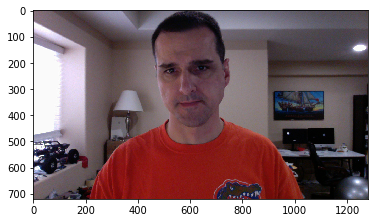

In [3]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)

cap.release()

In [8]:
# create a map to keep track of all these names
prop_map = {
    "pos_msec":cv2.CAP_PROP_POS_MSEC,
    "pos_frame":cv2.CAP_PROP_POS_FRAMES,
    "avi_ratio":cv2.CAP_PROP_POS_AVI_RATIO ,
    "width":cv2.CAP_PROP_FRAME_WIDTH ,
    "height":cv2.CAP_PROP_FRAME_HEIGHT ,
    "fps":cv2.CAP_PROP_FPS ,
    "fourcc":cv2.CAP_PROP_FOURCC ,
    "frame_count":cv2.CAP_PROP_FRAME_COUNT,
    "format":cv2.CAP_PROP_FORMAT ,
    "mode":cv2.CAP_PROP_MODE ,
    "brightness":cv2.CAP_PROP_BRIGHTNESS ,
    "contrast":cv2.CAP_PROP_CONTRAST ,
    "saturation":cv2.CAP_PROP_SATURATION,
    "hue":cv2.CAP_PROP_HUE ,
    "gain":cv2.CAP_PROP_GAIN ,
    "exposure":cv2.CAP_PROP_EXPOSURE ,
    "convert_rgb":cv2.CAP_PROP_CONVERT_RGB ,
 #   "white_balance":cv2.cv.CV_CAP_PROP_WHITE_BALANCE ,
    "rectification":cv2.CAP_PROP_RECTIFICATION}

# get a camera property
def get_prop(cam,name,prop_map):
    return cam.get(prop_map[name])

# set a camera property
def set_prop(cam,name,prop_map,value):
    cam.set(prop_map[name],value)

# print out all of the properites
def poll_props(cam,prop_map):
    out_map = {}
    for k,v in prop_map.items():
        result = cam.get(v)
        if( result == -1.0 ):
            out_map[k] = None
        else:
            out_map[k] = result
    return out_map

# create a camera and get its property
cam = cv2.VideoCapture(0)
properties = poll_props(cam,prop_map)

images = []

# list our properties
for k,v in properties.items():
    print("{0:<12}\t:{1:<12}".format(k,v))

# put our toys back on the shelf 
cam.release()

hue         	:0.0         
saturation  	:0.0         
format      	:16.0        
brightness  	:0.0         
pos_frame   	:0.0         
convert_rgb 	:0.0         
rectification	:0.0         
height      	:720.0       
contrast    	:0.0         
width       	:1280.0      
pos_msec    	:0.0         
fps         	:29.000049   
fourcc      	:0.0         
mode        	:0.0         
avi_ratio   	:0.0         
frame_count 	:0.0         
gain        	:0.0         
exposure    	:0.0         


# Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

![Pinhole Camera Model](images/pinhole_camera_model.png)

\begin{eqnarray}
  s p' = A[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)

The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

\begin{eqnarray}
  \begin{bmatrix} x \\ y \\ z \end{bmatrix} = R_{3x3}
  \begin{bmatrix} X \\ Y \\ Z \end{bmatrix} + t_{xyz} \\
  x' = \frac{x}{z} \\
  y' = \frac{y}{z} \\
  u = f_x*x'+c_x \\
  v = f_y*y'+c_y
\end{eqnarray}

However, there are always little distortions in the lense that break this model. Typically you must correct for radial ($k_{1-6}$) and tangential ($p_{1-2}$) distortions coefficients which effect the $x'$ and $y'$ terms in a nonlinear manor. The pictures below show the barrel distortion (typically $k_1 > 0$) and pincushion distortion (typically $k_1 < 0$).

![](images/distortion_examples.png)

## Calibration

So how do we do this? The calibration code does:

1. Converts image to grayscale
2. Searches for the intersections of the chessboard and should find 9x6 of them (i.e., 54 intersections)
3. Using homography (discussed later) and knowing that we are using a chessboard (other patterns are possible), it then uses an algorithm, typically RANSAC, to figure out the how the calibration target was warped inorder to match the image.

## OpenCV Calibration

OpenCV supports calibrating cameras based off a couple of patterns:

<span>
  <img src="images/checkerboard.jpg" width="30%"> 
  <img src="images/symetric-circles.jpg" width="30%"> 
  <img src="images/asymetric-circles.jpg" width="30%">  
</span>

# RANSAC

http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.ransac

Fit a model to data with the RANSAC (random sample consensus) algorithm.

RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. Each iteration performs the following tasks:

1. Select min_samples random samples from the original data and check whether the set of data is valid (see is_data_valid).
1. Estimate a model to the random subset (model_cls.estimate(*data[random_subset]) and check whether the estimated model is valid (see is_model_valid).
1. Classify all data as inliers or outliers by calculating the residuals to the estimated model (model_cls.residuals(*data)) - all data samples with residuals smaller than the residual_threshold are considered as inliers.
1. Save estimated model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has less sum of residuals.

What  you need to do, is get a lot of image of the target pattern and:

1. ..

![](images/cal-images.jpg)

Let's do an example

In [3]:
import opencvutils as cvu
from opencvutils.CameraCalibrate import CameraCalibration
print('OpenCV version {}'.format(cvu.get_opencv_version()))
import glob

OpenCV version (3, 3, 0)


In [4]:
calibration_images = 'cal_images/left*.jpg'
images = []
images = glob.glob(calibration_images)

In [17]:
# create a calibration instance called cal
cal = CameraCalibration()

# the pattern is a classic checkerboard
cal.marker_checkerboard = True

# calibrate using the images and the 9x6 checkerboard
# Note: 9x6 refers to the intersections, not the boxes
mat = cal.calibrate(images, alpha=1.0, marker_size=(9, 6))
cv2.destroyAllWindows()

[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners


The resulting camera info shows a low level of distortion, so the effect with and without the correction will be small to the human eye. However, for computer vision work, it will make a difference.

If we print out the camera matrix:

In [14]:
cal.printMatrix()

focal length 532.8 532.9
image center 342.5 233.9
radial distortion -0.281 0.027
tangental distortion 0.001 -0.000
RMS error: 0.196437908903


## Undistort Image

Now let's read back in an image and use the calibration matrix to undistort it.

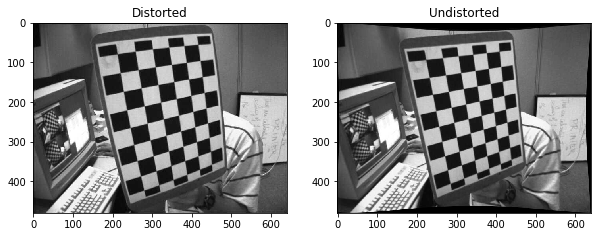

In [16]:
# read in a grayscale image
image = cv2.imread(images[12], 0)
dst = cal.undistort(image)

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray');
plt.title('Distorted')

plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray');
plt.title('Undistorted');

Hopefully you can see the waring in the middle of the image is gone in the right side. Cameras are made much better now, than they use to be, so for a lot of single camera applications this is not necessary. However, for stereo vision (2 or more cameras) or some of the 3D work, it is necessary to calibrate your cameras.

# Stereo Vision

Now we won't go into stereo vision, but show a simple example. The same idea we had before for the camera model can be expanded to 2 or more cameras.

![](images/stereo_frames.png)

Here we just have 2 single camera frames oriented side-by-side. Here we need both camera's calibrated as above, so straight lines are straight. We also need to understand the distance between each camera, called the baseline. Unfortunately, the calibration, orientation of the cameras (think mounting of the cameras to something), and distance between them has to be very accurate. Otherwise the math to calculate disparity (or reconstruct where things are in 3D space) will not work correctly.

![](images/stereo_matrix.png)

The reading for this lesson goes into more depth on stereo calibration.

The basic idea of calculating the disparity is:

![](images/stereo_depth.jpg)

which leads to $disparity = x - x' = \frac{Bf}{Z}$ where B is the baseline (shown as T above, sorry) and Z is the distance from the camera. Note, disparity is **not** the position in the world **unless** the world's origin is at the camera location (which is highly unlikely).

Also, algorithms that try to find stereo matches and calculate the disparity need calibrated cameras so that straight lines appear straight in the image. A common technique is to find key points in one image and then look in the second image alone the same row for the same key point. If the camera image is distorted, then key points won't appear where they are expected and the algorithm won't be able to calculate disparity.

In [31]:
imgL = cv2.imread('left.png',0)
imgR = cv2.imread('right.png',0)

stereo = cv2.StereoBM_create(numDisparities=11, blockSize=11)
# stereo.SADWindowSize = 11
# help(cv2.StereoBM_create)
# help(stereo)
# dir(cv2.StereoBM)
# disparity = stereo.compute(imgL,imgR)

# plt.imshow(disparity,'gray')

In [28]:
# help(cv2.solvePnPRansac)


# Exercises

- Try calculating the disparity for other picture in the stereo folder

# Questions

1. What are the equations to go from world to pixel coordinates according to the pinhold camera model?
1. Given 2 images, identify which image is distorted by pincushion distortion and which image is distorted by barrel distortion
1. What is the focal length of a camera mean?
1. In stereo vision, what is meant by disparity and camera baseline?
1. What type of calibration targets are available to use in OpenCV?
1. Why is calibrating a camera important?


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.